resume - continue execution with input from user without modifying the state


Operations with Interrupts (Các thao tác với ngắt quãng):

Resume - Tiếp tục thực thi với đầu vào từ người dùng mà không thay đổi trạng thái.

Update and Resume - Cập nhật trạng thái và sau đó tiếp tục thực thi.

Rewind/time Travel - Quay lại điểm kiểm tra trước đó trong quá trình thực thi.

Branch - Tạo một nhánh mới từ trạng thái hiện tại để khám phá các đường đi khác.

Abort - Hủy bỏ hoàn toàn quá trình thực thi hiện tại.

In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()

class State(TypedDict):
    value: str

def node_a(state: State): 
    print("Node A")
    return Command(
        goto="node_b", 
        update={
            "value": state["value"] + "a"
        }
    )

def node_b(state: State): 
    print("Node B")

    human_response = interrupt("Do you want to go to C or D? Type C/D")

    print("Human Review Values: ", human_response)
    
    if(human_response == "C"): 
        return Command(
            goto="node_c", 
            update={
                "value": state["value"] + "b"
            }
        ) 
    elif(human_response == "D"): 
        return Command(
            goto="node_d", 
            update={
                "value": state["value"] + "b"
            }
        )


def node_c(state: State): 
    print("Node C")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "c"
        }
    )

def node_d(state: State): 
    print("Node D")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "d"
        }
)

graph = StateGraph(State)

graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)

graph.set_entry_point("node_a") 

app = graph.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "1"}}

initialState = {
    "value": ""
}

first_result = app.invoke(initialState, config, stream_mode="updates")
first_result

Node A
Node B


[{'node_a': {'value': 'a'}},
 {'__interrupt__': (Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:de3ba237-e062-59cc-76f6-e68510c6fdfd']),)}]

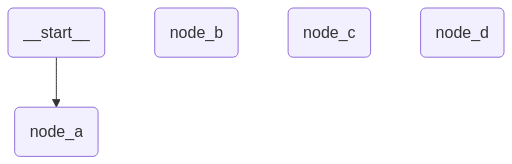

In [2]:
from IPython.display import display, Image 
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
print(app.get_state(config).next)
print(app.get_state(config))

('node_b',)
StateSnapshot(values={'value': 'a'}, next=('node_b',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f01d012-0298-6cd5-8001-5315a792ce51'}}, metadata={'source': 'loop', 'writes': {'node_a': {'value': 'a'}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-04-19T09:31:52.025199+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f01d012-0295-6d75-8000-11c1309937cb'}}, tasks=(PregelTask(id='de3ba237-e062-59cc-76f6-e68510c6fdfd', name='node_b', path=('__pregel_pull', 'node_b'), error=None, interrupts=(Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:de3ba237-e062-59cc-76f6-e68510c6fdfd']),), state=None, result=None),))


In [3]:
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
second_result

Node B
Human Review Values:  C
Node C


[{'node_b': {'value': 'ab'}}, {'node_c': {'value': 'abc'}}]